In [13]:
%pip install gurobipy
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [14]:
rnd = np.random
rnd.seed(51)

In [15]:
n = 8  # number of clients
f = 4  # number of charging stations
num_points = n + f + 1

# Generate random coordinates for xc and yc
xc = np.random.rand(num_points) * 200
yc = np.random.rand(num_points) * 100

# Randomly select f points from the generated points
selected_indices = np.random.choice(num_points, f, replace=False)
selected_xc = xc[selected_indices]
selected_yc = yc[selected_indices]

# Remove the selected points from xc and yc
xc = np.delete(xc, selected_indices)
yc = np.delete(yc, selected_indices)
xc=np.append(xc,xc[0])
yc=np.append(yc,yc[0])

print(xc)
print(yc)
num_of_copies = 2
# Append copies of each selected point after the first n points
for i in range(f):
    for _ in range(num_of_copies):
        xc = np.append(xc, selected_xc[i])
        yc = np.append(yc, selected_yc[i])
print("Remaining xc:", xc)
print("Remaining yc:", yc)

[135.1462831    8.94243644  68.66073451 128.8039454  189.86756133
  77.59459248 117.99873529  97.55915826  43.63651224 135.1462831 ]
[24.98314091 41.02479861  4.7725783  32.3548296  44.54105029 75.46383918
 72.87108304 56.47609387 58.23560806 24.98314091]
Remaining xc: [135.1462831    8.94243644  68.66073451 128.8039454  189.86756133
  77.59459248 117.99873529  97.55915826  43.63651224 135.1462831
  56.84259975  56.84259975  31.53403375  31.53403375  34.8686772
  34.8686772  129.34910884 129.34910884]
Remaining yc: [24.98314091 41.02479861  4.7725783  32.3548296  44.54105029 75.46383918
 72.87108304 56.47609387 58.23560806 24.98314091 29.22017587 29.22017587
  6.02748056  6.02748056 71.41213954 71.41213954 63.91391136 63.91391136]


18


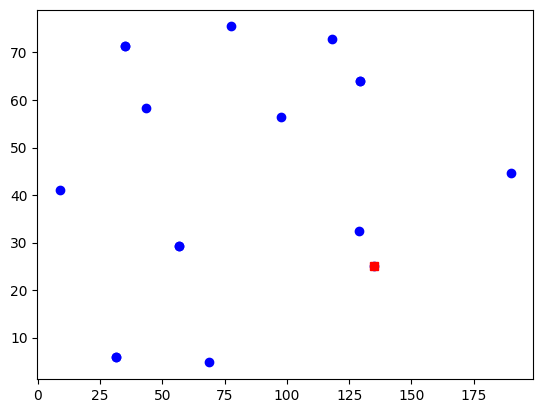

In [16]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
print(len(xc))

In [17]:
I = [i for i in range(1, n+1)] #Number of nodes/locations
F = [i for i in range(n+2,n+2+num_of_copies*f)]
N = I + F
F_depo = [0] + F
I_depo = [0] + N
I_dest = N + [n+1]
I_depo_dest = N + [0] + [n+1]
print(I_dest)
num_of_vehicles = 5
K = [i for i in range(1,num_of_vehicles+1)]
A = [(i, j, k) for i in I_depo for j in I_dest for k in K if i != j] 
dist = [(i, j) for i in I_depo for j in I_dest if i != j] 
total_with_vehicles = [(i,k) for i in I_depo_dest for k in K]
print("aman")
print(K)
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in dist} 

S = 10.0  
thresholds = [50, 100, 150, 200]
multipliers = [1.0, 1.19, 1.29, 1.39, 1.49]
t = {}

for i, j in c.keys():
    avg_value = (xc[i] + yc[i]) / 2
    for k in range(len(thresholds)):
        if avg_value <= thresholds[k]:
            t[i, j] = S * multipliers[k]
            break

lb = 14
ub = 20
C = {k: rnd.randint(lb, ub) for k in K}
q = {i: rnd.randint(1, 10) for i in N}
# for _ in range()
Q = 500
H = 50 
max_value = max(c.values())
Q = H*1.1*max_value
print(I)
print(F)
print(N)
print(q)
q[0]=0
for i in range(n+1,n+2+num_of_copies*f):
    q[i] = 0
print(q)
print(Q)
Q=10000
print(n+1)
print(C[1])

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 9]
aman
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6, 7, 8]
[10, 11, 12, 13, 14, 15, 16, 17]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17]
{1: 2, 2: 4, 3: 7, 4: 8, 5: 3, 6: 4, 7: 5, 8: 2, 10: 9, 11: 4, 12: 8, 13: 4, 14: 4, 15: 5, 16: 5, 17: 5}
{1: 2, 2: 4, 3: 7, 4: 8, 5: 3, 6: 4, 7: 5, 8: 2, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 0: 0, 9: 0}
9952.760981129817
9
19


In [18]:
from gurobipy import Model, GRB, quicksum

model = Model('ECVRP')
x = model.addVars(A, vtype=GRB.BINARY, name='x')
u = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, name='u')
y = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, ub=Q, name='y')
h = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS, name='h')

for i,k in u.keys():
    print(i,k)
    u[i,k].ub = C[k]
    u[i,k].lb = 0

model.modelSense = GRB.MINIMIZE
# u[0].setAttr(GRB.Attr.LB, C)
# u[0].setAttr(GRB.Attr.UB, C)
# y[0].setAttr(GRB.Attr.LB, Q)
# y[0].setAttr(GRB.Attr.UB, Q)

model.setObjective(quicksum(x[i, j, k]*c[i, j] for i, j, k in A))
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) == 1 for i in I), name='outgoing')
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) <= 1 for i in F), name='charging_outgoing')
model.addConstrs((quicksum(x[0, j, k] for j in N) <= 1 for k in K), name='charging_outgoing')
model.addConstrs((quicksum(x[i, j, k] for i in I_depo if i!=j)-quicksum(x[j,i,k] for i in I_dest if i!=j) == 0 for j in N for k in K), name='blockage')
model.addConstrs((u[j,k]<=u[i,k]-q[i]*x[i,j,k]+ C[k]*(1-x[i,j,k]) for i in I_depo for j in I_dest if i!=j for k in K), name='weight_transfer')
# model.addConstrs(quicksum(x[i,j,k]*c[i,j] for i in I_depo for j in I_dest if i!=j)<=290 for k in K)
model.addConstrs(quicksum(x[i,j,k]*t[i,j] for i in I_depo for j in I_dest if i!=j)<=50 for k in K)

# model.addConstrs((u[i]>=0 for i in I_dest), name='weight_lower_bound')
# model.addConstrs((u[0]<=C), name='weight_upper_bound')

Temp = 323
theta = 0.1
H = H*0.8 + Temp*(theta)
model.addConstrs(h[i,k] == H + u[i,k] / C[k] for i in I_depo_dest for k in K)
model.addConstrs((y[j,k]<=y[i,k]-h[i,k]*c[i,j]*x[i,j,k]+Q*(1-x[i,j,k]) for i in I for j in  I_dest  if i!=j for k in K), name = 'charge_left')
model.addConstrs((y[j,k]<=Q-h[i,k]*c[i,j]*x[i,j,k] for i in F_depo for j in I_dest  if i!=j for k in K), name='after leaving from charging station')
# model.addConstrs((y[i]>=0 for i in I_dest), name='charge_lower_bound')
# model.addConstrs((y[i]<=Q for i in N), name='charge_upper_bound')
# model.addConstr(u[0]==C, name='Specifying_constant_weight')
model.addConstrs((u[0,k]==C[k] for k in K), name='Specifying_constant_weight')
model.addConstrs((y[0,k]==Q for k in K), name='Specifying_constant_charge')
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 50  # seconds
model.optimize()
# optimal path -  active paths


1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5
6 1
6 2
6 3
6 4
6 5
7 1
7 2
7 3
7 4
7 5
8 1
8 2
8 3
8 4
8 5
10 1
10 2
10 3
10 4
10 5
11 1
11 2
11 3
11 4
11 5
12 1
12 2
12 3
12 4
12 5
13 1
13 2
13 3
13 4
13 5
14 1
14 2
14 3
14 4
14 5
15 1
15 2
15 3
15 4
15 5
16 1
16 2
16 3
16 4
16 5
17 1
17 2
17 3
17 4
17 5
0 1
0 2
0 3
0 4
0 5
9 1
9 2
9 3
9 4
9 5
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 50
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1571 rows, 1635 columns and 9570 nonzeros
Model fingerprint: 0x2d23dd98
Model has 1365 quadratic constraints
Variable types: 270 continuous, 1365 integer (1365 binary)
Coefficient statistics:
  Matrix range     [5e-02, 3e+01]
  QMatrix range    [1e+01, 2e+02]
  QLMatrix range   [1e+00, 1

In [19]:
# model.computeIIS()
model.write("model6.lp")

In [20]:
for var_name in u:
    u_var = u[var_name]
    print(f"{var_name} = {u_var.X}")

(1, 1) = 0.0
(1, 2) = 0.0
(1, 3) = 0.0
(1, 4) = 2.2737367544323206e-13
(1, 5) = 2.0
(2, 1) = 0.0
(2, 2) = 0.0
(2, 3) = 0.0
(2, 4) = 17.999999999999773
(2, 5) = 0.0
(3, 1) = 0.0
(3, 2) = 6.999999999999773
(3, 3) = 7.000000000000227
(3, 4) = -2.2737367544323206e-13
(3, 5) = 0.0
(4, 1) = 0.0
(4, 2) = 15.999999999999773
(4, 3) = 8.0
(4, 4) = 16.0
(4, 5) = 8.000000000000227
(5, 1) = 0.0
(5, 2) = 0.0
(5, 3) = 15.0
(5, 4) = -2.2737367544323206e-13
(5, 5) = 0.0
(6, 1) = 19.0
(6, 2) = 19.0
(6, 3) = 0.0
(6, 4) = -2.2737367544323206e-13
(6, 5) = 0.0
(7, 1) = 19.0
(7, 2) = 12.000000000000227
(7, 3) = 0.0
(7, 4) = -2.2737367544323206e-13
(7, 5) = 0.0
(8, 1) = 0.0
(8, 2) = 0.0
(8, 3) = 0.0
(8, 4) = 2.0
(8, 5) = 0.0
(10, 1) = 0.0
(10, 2) = 0.0
(10, 3) = 0.0
(10, 4) = -2.2737367544323206e-13
(10, 5) = 15.0
(11, 1) = 0.0
(11, 2) = 0.0
(11, 3) = 0.0
(11, 4) = 2.0000000000002274
(11, 5) = 0.0
(12, 1) = 19.0
(12, 2) = 0.0
(12, 3) = 0.0
(12, 4) = 5.0
(12, 5) = 0.0
(13, 1) = 19.0
(13, 2) = 0.0
(13, 3) = 0.0

In [21]:
for var_name in h:
    h_var = h[var_name]
    print(f"{var_name} = {h_var.X}")

(1, 1) = 72.30000000000001
(1, 2) = 72.30000000000001
(1, 3) = 72.30000000000001
(1, 4) = 72.30000000000003
(1, 5) = 72.43333333333335
(2, 1) = 72.30000000000001
(2, 2) = 72.30000000000001
(2, 3) = 72.30000000000001
(2, 4) = 73.30000000000001
(2, 5) = 72.30000000000001
(3, 1) = 72.30000000000001
(3, 2) = 72.66842105263159
(3, 3) = 72.7666666666667
(3, 4) = 72.30000000000001
(3, 5) = 72.30000000000001
(4, 1) = 72.30000000000001
(4, 2) = 73.1421052631579
(4, 3) = 72.83333333333334
(4, 4) = 73.18888888888891
(4, 5) = 72.83333333333336
(5, 1) = 72.30000000000001
(5, 2) = 72.30000000000001
(5, 3) = 73.30000000000001
(5, 4) = 72.30000000000001
(5, 5) = 72.30000000000001
(6, 1) = 73.30000000000001
(6, 2) = 73.30000000000001
(6, 3) = 72.30000000000001
(6, 4) = 72.30000000000001
(6, 5) = 72.30000000000001
(7, 1) = 73.30000000000001
(7, 2) = 72.93157894736845
(7, 3) = 72.30000000000001
(7, 4) = 72.30000000000001
(7, 5) = 72.30000000000001
(8, 1) = 72.30000000000001
(8, 2) = 72.30000000000001
(8,

In [22]:
for var_name in y:
    y_var = y[var_name]
    print(f"{var_name} = {y_var.X}")

(1, 1) = 0.0
(1, 2) = 0.0
(1, 3) = 6946.641415640668
(1, 4) = 0.0
(1, 5) = 6383.868906439451
(2, 1) = 0.0
(2, 2) = 0.0
(2, 3) = 0.0
(2, 4) = 4906.417328015656
(2, 5) = 0.0
(3, 1) = 0.0
(3, 2) = 706.6683249770199
(3, 3) = 712.8101515140838
(3, 4) = 706.8673656518323
(3, 5) = 0.0
(4, 1) = 5342.253118378971
(4, 2) = 9440.685667132953
(4, 3) = 5342.253118378971
(4, 4) = 9442.044997181229
(4, 5) = 7806.688106848987
(5, 1) = 0.0
(5, 2) = 0.0
(5, 3) = 3886.9261447453628
(5, 4) = 0.0
(5, 5) = 10000.0
(6, 1) = 4484.965209828552
(6, 2) = 6271.562952000373
(6, 3) = 1059.8427310692273
(6, 4) = 0.0
(6, 5) = 1059.8427310692273
(7, 1) = 7791.566672671614
(7, 2) = 3606.1386979424055
(7, 3) = 0.0
(7, 4) = 564.7472482823196
(7, 5) = 0.0
(8, 1) = 0.0
(8, 2) = 0.0
(8, 3) = 1160.1236946167473
(8, 4) = 7136.787312550399
(8, 5) = 4062.994774566354
(10, 1) = 0.0
(10, 2) = 0.0
(10, 3) = 0.0
(10, 4) = 0.0
(10, 5) = 0.0
(11, 1) = 0.0
(11, 2) = 0.0
(11, 3) = 0.0
(11, 4) = 0.0
(11, 5) = 0.0
(12, 1) = 0.0
(12, 2) =

[(0, 2, 4), (0, 5, 3), (0, 6, 2), (0, 10, 5), (1, 13, 5), (2, 11, 4), (3, 9, 2), (4, 9, 3), (5, 16, 3), (6, 7, 2), (7, 3, 2), (8, 9, 4), (10, 1, 5), (11, 8, 4), (13, 9, 5), (16, 4, 3)]


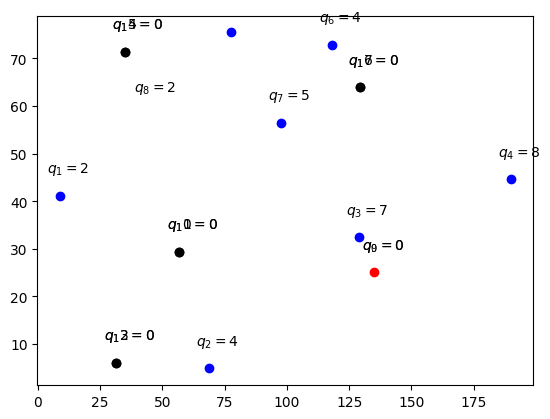

In [23]:
active_arcs = [a for a in A if x[a].x > 0.99]

print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
for i in I_depo_dest:
    plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-5, yc[i]+5))
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# number_of_vehicles=0
# for i,j,k in active_arcs:
#     if(i==0):
#        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = 'g')
plt.show()
# print(number_of_vehicles)

In [28]:
values = {}
vehicle_dist={}
vehicle_time={}
for i,j,k in active_arcs:
    if(k not in vehicle_dist):
      vehicle_dist[k] = c[i,j]
      vehicle_time[k] = t[i,j]
    else:
         vehicle_dist[k]+=c[i,j]
         vehicle_time[k]+=t[i,j]

    if i!=0:
        values[i]=(j,k)
for i in vehicle_dist.values():
     print(i)

for i in vehicle_time.values():
     print(i)
colors = ['magenta', 'green', 'red', 'yellow', 'cyan']
def rec(i, j,k,col):
        print((i,j,k))
        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = colors[col])
        if(j==n+1):
             return
        print("aman")
        print(values[j][0])
        rec(j,values[j][0],values[j][1],col)


225.88726441780685
251.23650449360457
126.26494347615372
274.7391073211001
43.8
48.599999999999994
47.599999999999994
41.9


[(0, 2, 4), (0, 5, 3), (0, 6, 2), (0, 10, 5), (1, 13, 5), (2, 11, 4), (3, 9, 2), (4, 9, 3), (5, 16, 3), (6, 7, 2), (7, 3, 2), (8, 9, 4), (10, 1, 5), (11, 8, 4), (13, 9, 5), (16, 4, 3)]
(0, 2, 4)
aman
11
(2, 11, 4)
aman
8
(11, 8, 4)
aman
9
(8, 9, 4)
(0, 5, 3)
aman
16
(5, 16, 3)
aman
4
(16, 4, 3)
aman
9
(4, 9, 3)
(0, 6, 2)
aman
7
(6, 7, 2)
aman
3
(7, 3, 2)
aman
9
(3, 9, 2)
(0, 10, 5)
aman
1
(10, 1, 5)
aman
13
(1, 13, 5)
aman
9
(13, 9, 5)


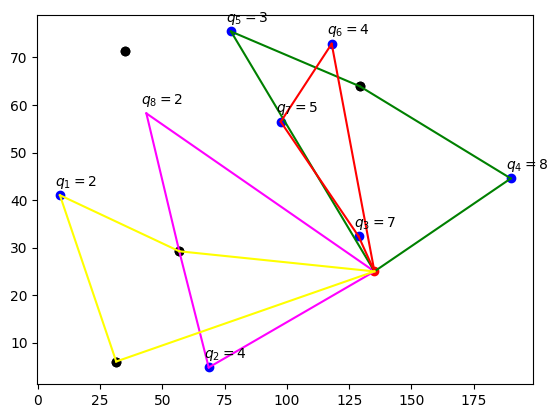

In [25]:
active_arcs = [a for a in A if x[a].x > 0.99]

print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
visited = []
for i in I:
    if(xc[i] not in visited):
      plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-2, yc[i]+2))
      visited.append(xc[i])
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# import random

# number_of_vehicles=0
col=0
# print(type(active_arcs))
for i,j,k in active_arcs:
    if(i==0):
        rec(i,j,k,col)
        col+=1
plt.show()
# print(number_of_vehicles)